In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.stats
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from _load_transform import load_transform
from _sample_split import create_sample_split
import statsmodels.api as sm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [3]:
df = load_transform()
with pd.option_context('display.max_rows', 10):
    display(df)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut
0,1,0,0.10000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
1,3,0,0.77000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
2,5,0,0.75000,B,6,1,5,50,B12,Diesel,54,R22,0.0,0.0
3,10,0,0.09000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0
4,11,0,0.84000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0,0.00274,E,4,0,5,50,B12,Regular,3317,R93,0.0,0.0
678009,6114327,0,0.00274,E,4,0,4,95,B12,Regular,9850,R11,0.0,0.0
678010,6114328,0,0.00274,D,6,1,4,50,B12,Diesel,1323,R82,0.0,0.0
678011,6114329,0,0.00274,B,4,0,5,50,B12,Regular,95,R26,0.0,0.0


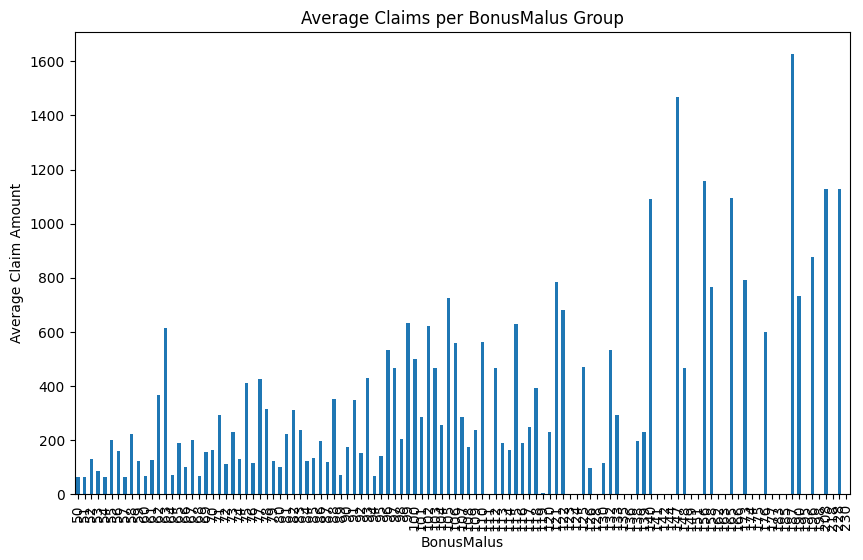

In [4]:
weighted_avg = df.groupby('BonusMalus').apply(
    lambda x: np.average(x['ClaimAmount'], weights=x['Exposure'])
)
plt.figure(figsize=(10, 6))
weighted_avg.plot(kind='bar')
plt.title('Average Claims per BonusMalus Group')
plt.xlabel('BonusMalus')
plt.ylabel('Average Claim Amount')
plt.show()


In [10]:
df = create_sample_split(df, id_column='IDpol', training_frac=0.8)
train_df = df[df['sample'] == 'train']
test_df = df[df['sample'] == 'test']
test_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut,sample
598019,5000002,0,0.03000,D,4,1,6,80,B6,Regular,645,R94,0.0,0.0,test
598020,5000004,0,0.19000,D,4,1,6,76,B6,Regular,645,R94,0.0,0.0,test
598021,5000006,0,0.03000,E,9,1,5,76,B12,Regular,5433,R93,0.0,0.0,test
598022,5000008,0,0.46000,E,9,1,5,95,B12,Regular,5433,R93,0.0,0.0,test
598023,5000010,0,0.03000,B,9,1,5,50,B12,Regular,54,R91,0.0,0.0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0,0.00274,E,4,0,5,50,B12,Regular,3317,R93,0.0,0.0,test
678009,6114327,0,0.00274,E,4,0,4,95,B12,Regular,9850,R11,0.0,0.0,test
678010,6114328,0,0.00274,D,6,1,4,50,B12,Diesel,1323,R82,0.0,0.0,test
678011,6114329,0,0.00274,B,4,0,5,50,B12,Regular,95,R26,0.0,0.0,test


In [18]:
X = df[['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus','Density']]
y = df['ClaimAmount']
X = pd.get_dummies(X, drop_first=True)

X_train = train_df[['ClaimNb', 'Exposure' , 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']]
X_test = test_df[['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']]
y_train = train_df['ClaimAmount']
y_test = test_df['ClaimAmount']

X_test


,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
598019,0,0.03000,4,1,6,80,645
598020,0,0.19000,4,1,6,76,645
598021,0,0.03000,9,1,5,76,5433
598022,0,0.46000,9,1,5,95,5433
598023,0,0.03000,9,1,5,50,54
...,...,...,...,...,...,...,...
678008,0,0.00274,4,0,5,50,3317
678009,0,0.00274,4,0,4,95,9850
678010,0,0.00274,6,1,4,50,1323
678011,0,0.00274,4,0,5,50,95


In [20]:
bonus_malus_index = X.columns.get_loc("BonusMalus")  
monotone_constraints = [0] * len(X.columns)
monotone_constraints[bonus_malus_index] = 1 

model_constrained = LGBMRegressor(monotone_constraints=monotone_constraints)
model_unconstrained = LGBMRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cross_validate_model(model, X, y, kf):
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_kf, y_train_kf)
        y_pred_kf = model.predict(X_test_kf)
        rmse = np.sqrt(mean_squared_error(y_test_kf, y_pred_kf))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Evaluate models
rmse_constrained = cross_validate_model(model_constrained, X_train, y_train, kf)
rmse_unconstrained = cross_validate_model(model_unconstrained, X_train, y_train, kf)

print(f"Average RMSE (Constrained): {rmse_constrained}")
print(f"Average RMSE (Unconstrained): {rmse_unconstrained}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 478415, number of used features: 7
[LightGBM] [Info] Start training from score 93.208476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 478415, number of used features: 7
[LightGBM] [Info] Start training from score 93.828408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [36]:
#1.b
X = df.drop(columns=['ClaimAmount', 'ClaimAmountCut', 'sample'])  
y = df['ClaimAmount'] 
categorical_features = ['Area', 'VehBrand', 'VehGas', 'Region']
numerical_features = ['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

X_train = train_df.drop(columns=['ClaimAmount', 'ClaimAmountCut', 'sample'])  
X_test = test_df.drop(columns=['ClaimAmount', 'ClaimAmountCut', 'sample'])  
y_train = train_df['ClaimAmount'] 
y_test = test_df['ClaimAmount']


In [37]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ],
    remainder='drop' 
)


column_transformer.fit(X_train)
all_features = column_transformer.get_feature_names_out()

bonus_malus_index = np.where(all_features == 'num__BonusMalus')[0][0]  
monotone_constraints = [0] * len(all_features)
monotone_constraints[bonus_malus_index] = 1  

constrained_lgbm = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('regressor', LGBMRegressor(monotone_constraints=monotone_constraints))
])


constrained_lgbm.fit(X_train, y_train)
predictions = constrained_lgbm.predict(X_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 598019, number of used features: 44
[LightGBM] [Info] Start training from score 93.365329


In [39]:
#1.c
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ],
    remainder='drop'
)

column_transformer.fit(X_train) 
all_features = column_transformer.get_feature_names_out()
bonus_malus_index = np.where(all_features == 'num__BonusMalus')[0][0]
monotone_constraints = [0] * len(all_features)
monotone_constraints[bonus_malus_index] = 1

pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('regressor', LGBMRegressor(monotone_constraints=monotone_constraints))
])


param_grid = {
    'regressor__num_leaves': [31, 41], 
    'regressor__max_depth': [-1, 10]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
X_test['pp_t_lgbm_constrained'] = predictions
X_test.to_csv('test_predictions.csv', index=False)

print("Best model parameters:", grid_search.best_params_)
print("Cross-validation results:", grid_search.cv_results_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 478415, number of used features: 44
[LightGBM] [Info] Start training from score 90.174425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 478415, number of used features: 44
[LightGBM] [Info] Start training from score 86.390973
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003923 seconds.
You can set `force_row